In [17]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import pearsonr
import seaborn as sns

In [10]:
df_vp = pd.read_excel("../raw_data/viability_vs_proliferation.xlsx")
df_vp = df_vp.rename(columns={"Celular line": "CellLine"})
df_vp["CellLine"] = df_vp["CellLine"].astype(str).str.strip()
df_vp["Enzyme"] = df_vp["Enzyme"].astype(str).str.strip()
df_vp["Treatment"] = pd.to_numeric(df_vp["Treatment"], errors="coerce")
df_vp["Viability"] = pd.to_numeric(df_vp["Viability"], errors="coerce")
df_vp = df_vp.dropna(subset=["CellLine", "Enzyme", "Treatment", "Viability"])

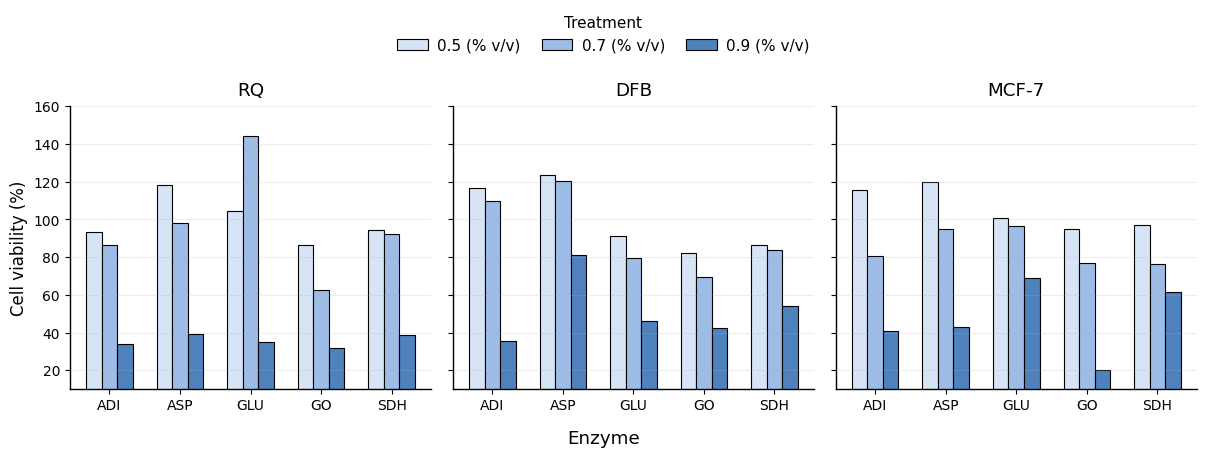

In [11]:
# ============================================================
# CORE 2A — Barplot: Viability vs Enzyme, faceted by Cell line
# ============================================================

# df_vp should already be loaded from viability_vs_proliferation.xlsx
# Safety check
required_cols = {"CellLine", "Enzyme", "Treatment", "Viability", "Proliferation"}
missing = required_cols - set(df_vp.columns)
if missing:
    raise ValueError(f"df_vp is missing required columns: {missing}")

# Orders
cell_order = ["RQ", "DFB", "MCF-7"]
enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]
treat_order = [0.5, 0.7, 0.9]

# Pastel blue palette by treatment (consistent with previous figs)
treat_blue = {
    0.5: "#D6E4F5",
    0.7: "#9DBCE6",
    0.9: "#4F81BD",
}

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
})

fig, axes = plt.subplots(1, 3, figsize=(12.2, 4.2), sharey=True)
axes = np.atleast_1d(axes)

# Global y-limits for Viability
y_min = max(0, np.floor(df_vp["Viability"].min() / 10) * 10 - 10)
y_max = np.ceil(df_vp["Viability"].max() / 10) * 10 + 10

bar_width = 0.22
x = np.arange(len(enzyme_order))

for ax, cl in zip(axes, cell_order):
    dcl = df_vp[df_vp["CellLine"] == cl].copy()

    for i, t in enumerate(treat_order):
        dt = dcl[dcl["Treatment"] == t].set_index("Enzyme").reindex(enzyme_order)
        vals = dt["Viability"].values

        offsets = (i - (len(treat_order) - 1) / 2) * bar_width
        xpos = x + offsets

        ax.bar(
            xpos,
            vals,
            width=bar_width,
            color=treat_blue[t],
            edgecolor="black",
            linewidth=0.8,
            label=f"{t:g} (% v/v)" if cl == cell_order[0] else None
        )

    ax.set_title(cl, pad=8)
    ax.set_xticks(x)
    ax.set_xticklabels(enzyme_order)
    ax.set_ylim(y_min, y_max)

    ax.grid(axis="y", alpha=0.22, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Cell viability (%)")
fig.supxlabel("Enzyme", y=0.04)

# Legend (shared, on top)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Treatment",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=3,
    frameon=False,
    columnspacing=1.4,
    handletextpad=0.6
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### **Figure 1 – Enzyme- and dose-dependent modulation of cell viability across cell lines**

Across all three cell lines, cell viability exhibits a clear enzyme- and dose-dependent modulation, with consistent trends observed across treatment levels. In RQ cells, ASP and GLU display the highest viability values at 0.5 and 0.7% (v/v), with GLU showing a marked increase at 0.7% (v/v), whereas all enzymes exhibit a pronounced reduction at 0.9% (v/v), indicating a strong dose-dependent cytotoxic effect at higher concentrations. In DFB cells, ASP again shows the highest viability at lower doses, followed by ADI, while GLU, GO, and SDH display progressively lower viability, particularly at 0.9% (v/v). In MCF-7 cells, ASP and GLU maintain comparatively higher viability at 0.5 and 0.7% (v/v), whereas GO shows a pronounced decrease, especially at 0.9% (v/v), suggesting increased sensitivity of this cell line to this enzyme at higher concentrations. Notably, although the overall trend of reduced viability at 0.9% (v/v) is conserved across all cell lines, the relative ranking of enzymes differs between RQ, DFB, and MCF-7, highlighting a strong cell line–specific component in enzyme-mediated viability responses.



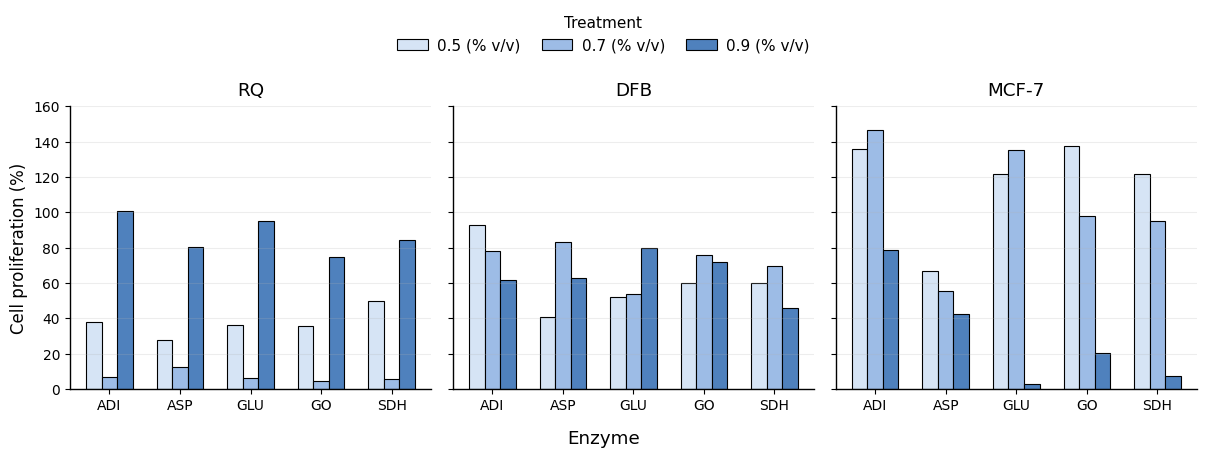

In [12]:
# ============================================================
# CORE 2B — Barplot: Proliferation vs Enzyme, faceted by Cell line
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(12.2, 4.2), sharey=True)
axes = np.atleast_1d(axes)

# Global y-limits for Proliferation
y_min = max(0, np.floor(df_vp["Proliferation"].min() / 10) * 10 - 10)
y_max = np.ceil(df_vp["Proliferation"].max() / 10) * 10 + 10

for ax, cl in zip(axes, cell_order):
    dcl = df_vp[df_vp["CellLine"] == cl].copy()

    for i, t in enumerate(treat_order):
        dt = dcl[dcl["Treatment"] == t].set_index("Enzyme").reindex(enzyme_order)
        vals = dt["Proliferation"].values

        offsets = (i - (len(treat_order) - 1) / 2) * bar_width
        xpos = x + offsets

        ax.bar(
            xpos,
            vals,
            width=bar_width,
            color=treat_blue[t],
            edgecolor="black",
            linewidth=0.8,
            label=f"{t:g} (% v/v)" if cl == cell_order[0] else None
        )

    ax.set_title(cl, pad=8)
    ax.set_xticks(x)
    ax.set_xticklabels(enzyme_order)
    ax.set_ylim(y_min, y_max)

    ax.grid(axis="y", alpha=0.22, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Cell proliferation (%)")
fig.supxlabel("Enzyme", y=0.04)

# Legend (shared, on top)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Treatment",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=3,
    frameon=False,
    columnspacing=1.4,
    handletextpad=0.6
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### **Figure 2 – Enzyme- and dose-dependent modulation of cell proliferation across cell lines**

Cell proliferation displays marked enzyme-, dose-, and cell line–dependent variability, with patterns that differ substantially from those observed for cell viability. In RQ cells, all enzymes induce low proliferation at 0.5 and 0.7% (v/v), whereas a pronounced increase is observed at 0.9% (v/v) for ADI, GLU, and SDH, indicating a strong dose-dependent proliferative response at higher concentrations. In contrast, DFB cells exhibit more moderate and heterogeneous responses, with ADI and ASP showing higher proliferation at 0.5 and 0.7% (v/v), GLU peaking at 0.9% (v/v), and SDH displaying a decrease at the highest dose. In MCF-7 cells, proliferation levels are substantially higher overall, with ADI, GLU, and GO showing elevated proliferation at 0.5 and 0.7% (v/v), followed by a sharp reduction at 0.9% (v/v), particularly for GLU, GO, and SDH. Notably, the direction and magnitude of dose-dependent changes in proliferation are not conserved across cell lines, and in several cases diverge from the corresponding viability trends, highlighting a complex and context-dependent relationship between enzyme treatment, dose, and proliferative behavior.


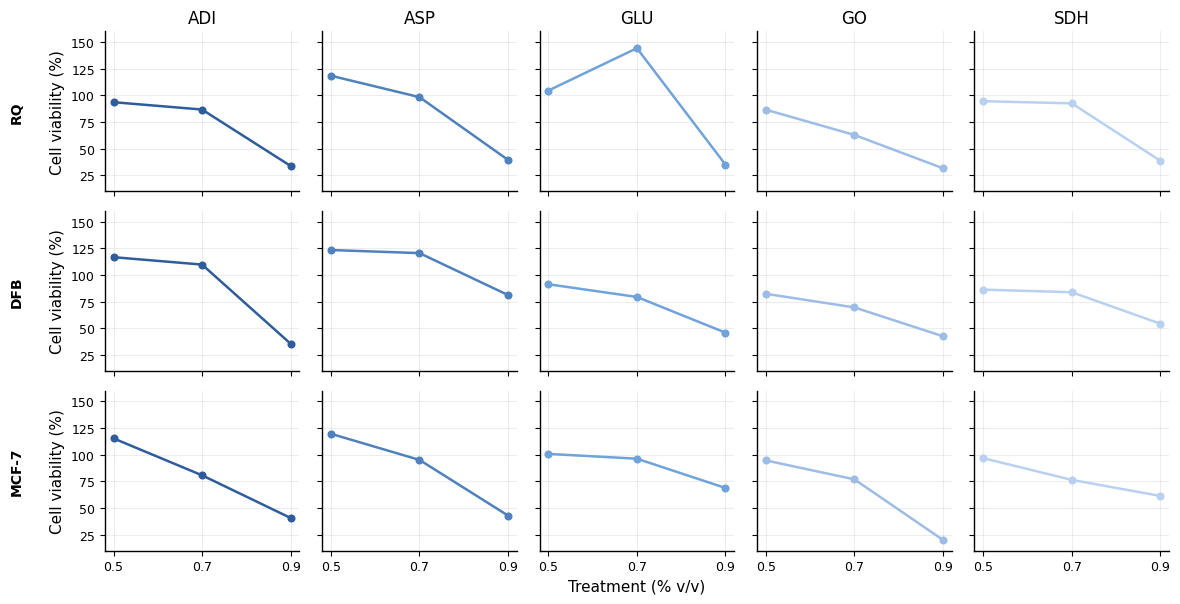

In [13]:
# ============================================================
# CORE 3A — Dose–response: Viability vs Treatment
# Rows = Cell line | Cols = Enzyme
# ============================================================

# Safety
required_cols = {"CellLine", "Enzyme", "Treatment", "Viability", "Proliferation"}
missing = required_cols - set(df_vp.columns)
if missing:
    raise ValueError(f"df_vp is missing required columns: {missing}")

cell_order = ["RQ", "DFB", "MCF-7"]
enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]
treat_order = [0.5, 0.7, 0.9]

# Enzyme colors (blue family)
enzyme_blue = {
    "ADI": "#2F5D9B",
    "ASP": "#4F81BD",
    "GLU": "#6FA3D9",
    "GO":  "#9DBCE6",
    "SDH": "#B9D1F0",
}

plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.linewidth": 1.0,
})

nrows, ncols = len(cell_order), len(enzyme_order)
fig, axes = plt.subplots(nrows, ncols, figsize=(2.35*ncols, 2.05*nrows), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

# Global y-limits
y_min = max(0, np.floor(df_vp["Viability"].min() / 10) * 10 - 10)
y_max = np.ceil(df_vp["Viability"].max() / 10) * 10 + 10

for i, cl in enumerate(cell_order):
    for j, enz in enumerate(enzyme_order):
        ax = axes[i, j]
        d = df_vp[(df_vp["CellLine"] == cl) & (df_vp["Enzyme"] == enz)].copy()
        d = d.set_index("Treatment").reindex(treat_order).reset_index()

        ax.plot(
            d["Treatment"], d["Viability"],
            marker="o",
            color=enzyme_blue.get(enz, "#4F81BD"),
            linewidth=1.8,
            markersize=4.8
        )

        ax.set_ylim(y_min, y_max)
        ax.grid(alpha=0.22, linewidth=0.8)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Column titles (enzymes)
        if i == 0:
            ax.set_title(enz, pad=6)

        # Row labels (cell lines)
        if j == 0:
            ax.set_ylabel("Cell viability (%)")
            ax.text(-0.45, 0.5, cl, transform=ax.transAxes,
                    rotation=90, ha="center", va="center",
                    fontsize=10, fontweight="bold")

        ax.set_xticks(treat_order)
        ax.set_xticklabels([f"{t:g}" for t in treat_order])

# X label only on bottom middle-ish
axes[-1, ncols//2].set_xlabel("Treatment (% v/v)")

plt.tight_layout()
plt.show()

### **Figure 3 – Dose-dependent effects of enzyme treatment on cell viability across cell lines**

Dose–response profiles reveal distinct and enzyme-specific patterns of cell viability modulation across the three cell lines. In RQ cells, ADI, ASP, GO, and SDH exhibit a monotonic decrease in viability with increasing treatment concentration, whereas GLU shows a non-monotonic profile characterized by a pronounced increase at 0.7% (v/v) followed by a sharp reduction at 0.9% (v/v). In DFB cells, all enzymes display a consistent decline in viability as treatment concentration increases, with ADI and ASP maintaining comparatively higher viability at 0.5 and 0.7% (v/v) before dropping markedly at 0.9% (v/v). In MCF-7 cells, a similar overall downward trend is observed for all enzymes; however, the magnitude of the decrease varies substantially, with GO and SDH showing particularly strong reductions at 0.9% (v/v). Notably, the slope and shape of the dose–response curves differ between enzymes and cell lines, indicating that both enzyme identity and cellular context strongly influence the sensitivity of viability to increasing treatment concentration.

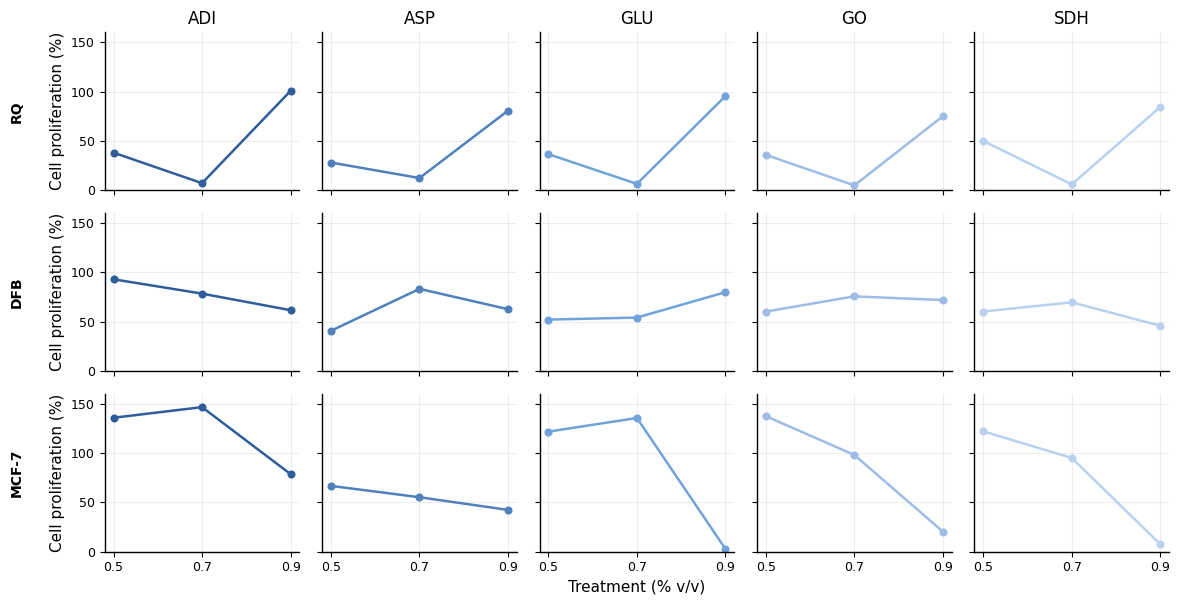

In [14]:
# ============================================================
# CORE 3B — Dose–response: Proliferation vs Treatment
# Rows = Cell line | Cols = Enzyme
# ============================================================

fig, axes = plt.subplots(nrows, ncols, figsize=(2.35*ncols, 2.05*nrows), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

# Global y-limits
y_min = max(0, np.floor(df_vp["Proliferation"].min() / 10) * 10 - 10)
y_max = np.ceil(df_vp["Proliferation"].max() / 10) * 10 + 10

for i, cl in enumerate(cell_order):
    for j, enz in enumerate(enzyme_order):
        ax = axes[i, j]
        d = df_vp[(df_vp["CellLine"] == cl) & (df_vp["Enzyme"] == enz)].copy()
        d = d.set_index("Treatment").reindex(treat_order).reset_index()

        ax.plot(
            d["Treatment"], d["Proliferation"],
            marker="o",
            color=enzyme_blue.get(enz, "#4F81BD"),
            linewidth=1.8,
            markersize=4.8
        )

        ax.set_ylim(y_min, y_max)
        ax.grid(alpha=0.22, linewidth=0.8)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Column titles
        if i == 0:
            ax.set_title(enz, pad=6)

        # Row labels
        if j == 0:
            ax.set_ylabel("Cell proliferation (%)")
            ax.text(-0.45, 0.5, cl, transform=ax.transAxes,
                    rotation=90, ha="center", va="center",
                    fontsize=10, fontweight="bold")

        ax.set_xticks(treat_order)
        ax.set_xticklabels([f"{t:g}" for t in treat_order])

axes[-1, ncols//2].set_xlabel("Treatment (% v/v)")

plt.tight_layout()
plt.show()

### **Figure 4 – Dose-dependent effects of enzyme treatment on cell proliferation across cell lines**

Dose–response profiles of cell proliferation reveal pronounced enzyme- and cell line–specific patterns, with several non-monotonic and divergent trends across treatments. In RQ cells, all enzymes display a characteristic U-shaped response, with proliferation decreasing at 0.7% (v/v) followed by a marked increase at 0.9% (v/v), most prominently for ADI, GLU, and SDH. In contrast, DFB cells exhibit more gradual and heterogeneous responses, with ADI showing a steady decline in proliferation with increasing dose, ASP peaking at 0.7% (v/v), and GLU, GO, and SDH displaying moderate increases or plateaus at higher concentrations. In MCF-7 cells, proliferation is high at 0.5 and 0.7% (v/v) for most enzymes, followed by a pronounced reduction at 0.9% (v/v), particularly for GLU, GO, and SDH, indicating strong dose sensitivity at higher concentrations. Notably, the direction and magnitude of proliferative responses are not conserved across cell lines or enzymes, and in several cases diverge from the corresponding viability trends, underscoring a complex, context-dependent relationship between enzyme treatment, dose, and proliferative behavior.

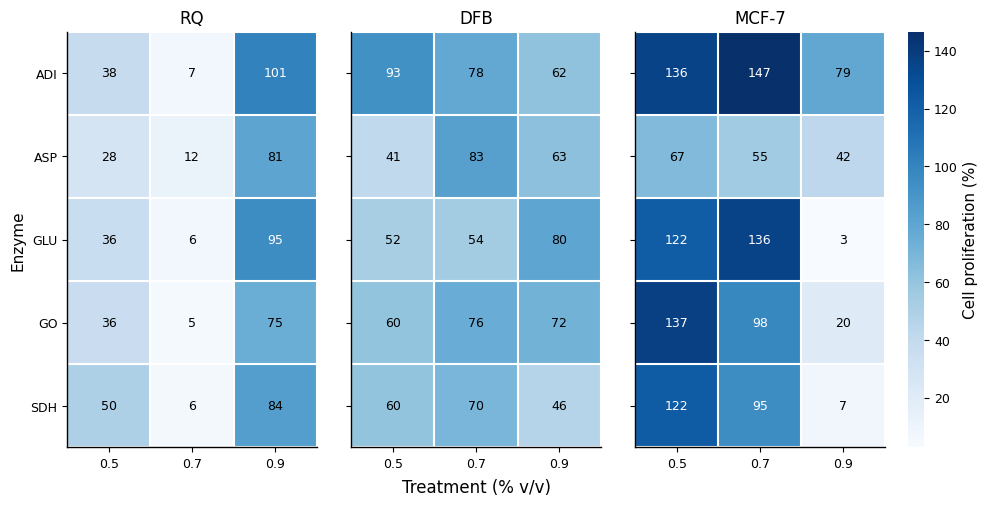

In [21]:
# ============================================================
# FIXED — Compact heatmaps (3 panels) with a single shared colorbar
# Works for either "Viability" or "Proliferation"
# ============================================================

cell_order = ["RQ", "DFB", "MCF-7"]
enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]
treat_order = [0.5, 0.7, 0.9]

value_col = "Proliferation"  # <-- change to "Viability" if needed
cbar_label = "Cell proliferation (%)" if value_col == "Proliferation" else "Cell viability (%)"

# Build matrices
mats = {}
for cl in cell_order:
    dcl = df_vp[df_vp["CellLine"] == cl]
    mat = (
        dcl.pivot(index="Enzyme", columns="Treatment", values=value_col)
           .reindex(index=enzyme_order, columns=treat_order)
    )
    mats[cl] = mat

# Shared color scale across panels
vmin = min(m.min().min() for m in mats.values())
vmax = max(m.max().max() for m in mats.values())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.Blues

plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.linewidth": 1.0,
})

# --- Use GridSpec to control spacing and reserve a column for the colorbar
fig = plt.figure(figsize=(11.2, 5.4))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.06], wspace=0.06)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])  # colorbar axis

# Plot panels
im_ref = None
for ax, cl in zip(axes, cell_order):
    mat = mats[cl]

    im = ax.imshow(mat.values, cmap=cmap, norm=norm, aspect="equal")
    im_ref = im

    ax.set_title(cl, pad=6)

    # ticks
    ax.set_xticks(np.arange(len(treat_order)))
    ax.set_xticklabels([f"{t:g}" for t in treat_order])
    ax.set_yticks(np.arange(len(enzyme_order)))

    if ax is axes[0]:
        ax.set_yticklabels(enzyme_order)
        ax.set_ylabel("Enzyme")
    else:
        ax.set_yticklabels([])

    # gridlines
    ax.set_xticks(np.arange(-0.5, len(treat_order), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(enzyme_order), 1), minor=True)
    ax.grid(which="minor", color="white", linewidth=1.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # annotations (auto color for readability)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.iloc[i, j]
            if np.isnan(val):
                txt = "NA"
                color = "black"
            else:
                txt = f"{val:.0f}"
                rgba = cmap(norm(val))
                luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
                color = "white" if luminance < 0.55 else "black"

            ax.text(j, i, txt, ha="center", va="center", fontsize=9, color=color)

    # clean spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Shared xlabel
fig.supxlabel("Treatment (% v/v)", y=0.02)

# Single colorbar (no overlap)
cbar = fig.colorbar(im_ref, cax=cax)
cbar.set_label(cbar_label)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()

### **Figure 5 – Heatmap representation of enzyme- and dose-dependent effects on cell proliferation across cell lines**

Heatmap visualization highlights pronounced heterogeneity in cell proliferation responses across enzymes, treatment levels, and cell lines. In RQ cells, proliferation remains low at 0.5 and 0.7% (v/v) for all enzymes, followed by a marked increase at 0.9% (v/v), particularly for ADI, GLU, and SDH, indicating a strong dose-dependent induction of proliferative activity at the highest concentration. In contrast, DFB cells display more moderate and balanced proliferation levels across all treatments, with ASP, GO, and SDH showing peak values at 0.7% (v/v), while GLU reaches its maximum at 0.9% (v/v). MCF-7 cells exhibit a strikingly different pattern, characterized by high proliferation at 0.5 and 0.7% (v/v) for ADI, GLU, GO, and SDH, followed by a dramatic reduction at 0.9% (v/v), particularly for GLU, GO, and SDH. Notably, ASP shows consistently lower proliferation in MCF-7 across all doses. Overall, these patterns underscore strong cell line–specific and enzyme-specific modulation of proliferative responses, as well as non-linear dose effects that differ substantially between cellular contexts.

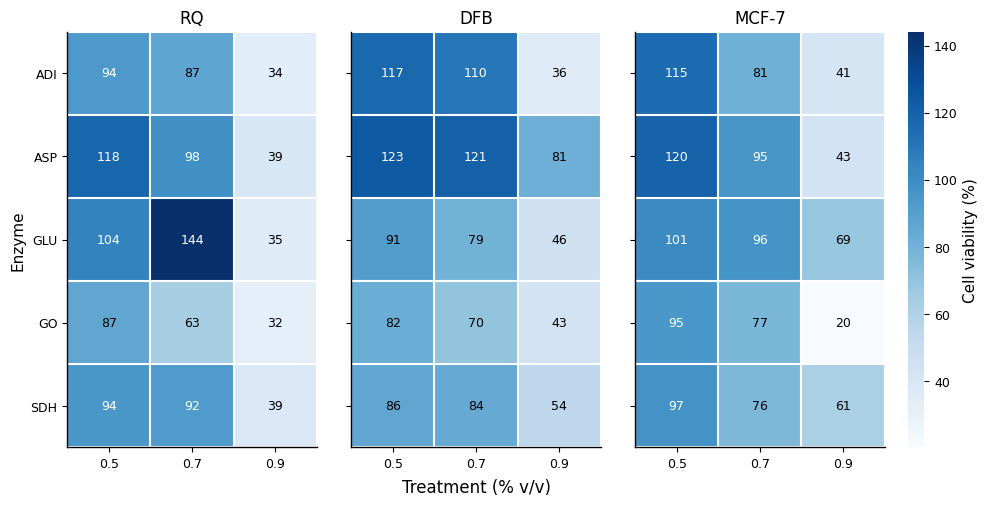

In [22]:
# ============================================================
# FIXED — Compact heatmaps (3 panels) with a single shared colorbar
# Works for either "Viability" or "Proliferation"
# ============================================================

cell_order = ["RQ", "DFB", "MCF-7"]
enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]
treat_order = [0.5, 0.7, 0.9]

value_col = "Viability"  # <-- change to "Viability" if needed
cbar_label = "Cell proliferation (%)" if value_col == "Proliferation" else "Cell viability (%)"

# Build matrices
mats = {}
for cl in cell_order:
    dcl = df_vp[df_vp["CellLine"] == cl]
    mat = (
        dcl.pivot(index="Enzyme", columns="Treatment", values=value_col)
           .reindex(index=enzyme_order, columns=treat_order)
    )
    mats[cl] = mat

# Shared color scale across panels
vmin = min(m.min().min() for m in mats.values())
vmax = max(m.max().max() for m in mats.values())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.Blues

plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.linewidth": 1.0,
})

# --- Use GridSpec to control spacing and reserve a column for the colorbar
fig = plt.figure(figsize=(11.2, 5.4))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.06], wspace=0.06)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])  # colorbar axis

# Plot panels
im_ref = None
for ax, cl in zip(axes, cell_order):
    mat = mats[cl]

    im = ax.imshow(mat.values, cmap=cmap, norm=norm, aspect="equal")
    im_ref = im

    ax.set_title(cl, pad=6)

    # ticks
    ax.set_xticks(np.arange(len(treat_order)))
    ax.set_xticklabels([f"{t:g}" for t in treat_order])
    ax.set_yticks(np.arange(len(enzyme_order)))

    if ax is axes[0]:
        ax.set_yticklabels(enzyme_order)
        ax.set_ylabel("Enzyme")
    else:
        ax.set_yticklabels([])

    # gridlines
    ax.set_xticks(np.arange(-0.5, len(treat_order), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(enzyme_order), 1), minor=True)
    ax.grid(which="minor", color="white", linewidth=1.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # annotations (auto color for readability)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.iloc[i, j]
            if np.isnan(val):
                txt = "NA"
                color = "black"
            else:
                txt = f"{val:.0f}"
                rgba = cmap(norm(val))
                luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
                color = "white" if luminance < 0.55 else "black"

            ax.text(j, i, txt, ha="center", va="center", fontsize=9, color=color)

    # clean spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Shared xlabel
fig.supxlabel("Treatment (% v/v)", y=0.02)

# Single colorbar (no overlap)
cbar = fig.colorbar(im_ref, cax=cax)
cbar.set_label(cbar_label)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()

### **Figure 6 – Heatmap representation of enzyme- and dose-dependent effects on cell viability across cell lines**

The heatmap representation reveals clear enzyme-, dose-, and cell line–dependent patterns in cell viability. In RQ cells, ASP and GLU exhibit the highest viability at 0.5 and 0.7% (v/v), with GLU reaching a pronounced peak at 0.7% (v/v), followed by a sharp reduction for all enzymes at 0.9% (v/v). In DFB cells, ADI and ASP consistently maintain high viability at 0.5 and 0.7% (v/v), whereas GLU, GO, and SDH show more moderate values, with all enzymes exhibiting a substantial decrease at 0.9% (v/v). In MCF-7 cells, ADI, ASP, and GLU display elevated viability at lower doses, while GO shows comparatively lower values across treatments. Notably, viability decreases at 0.9% (v/v) are particularly pronounced for GO and ADI in MCF-7 cells. Across all cell lines, the transition from 0.7 to 0.9% (v/v) is associated with a marked drop in viability, indicating a strong and conserved dose-dependent effect, while the relative ranking of enzymes differs between cellular contexts, highlighting cell line–specific sensitivity to enzyme treatment.


In [27]:
# ============================================================
# CORE 5.1 — PCA: Viability + Proliferation (exploratory)
# ============================================================

# Features
X = df_vp[["Viability", "Proliferation"]].values
meta = df_vp[["CellLine", "Enzyme", "Treatment"]].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = meta.copy()
df_pca["PC1"] = X_pca[:, 0]
df_pca["PC2"] = X_pca[:, 1]

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.50541726 0.49458274]


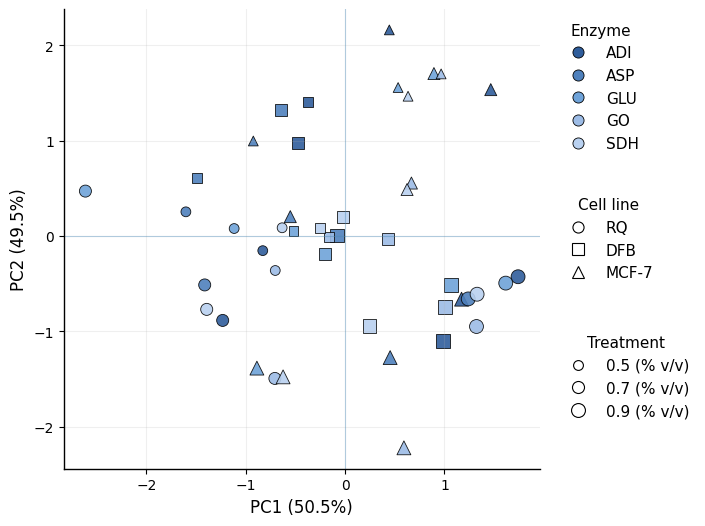

In [28]:
# ============================================================
# CORE 5.1 — PCA scatter with clean legends (enzyme, cell line, treatment)
# ============================================================

# --- PCA already computed as df_pca with columns:
# PC1, PC2, Enzyme, CellLine, Treatment

enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]
cell_order = ["RQ", "DFB", "MCF-7"]

enzyme_blue = {
    "ADI": "#2F5D9B",
    "ASP": "#4F81BD",
    "GLU": "#6FA3D9",
    "GO":  "#9DBCE6",
    "SDH": "#B9D1F0",
}

cell_marker = {
    "RQ": "o",
    "DFB": "s",
    "MCF-7": "^",
}

treat_size = {
    0.5: 50,
    0.7: 75,
    0.9: 100,
}

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
})

fig, ax = plt.subplots(figsize=(7.2, 5.4))

# --- Plot points
for enz in enzyme_order:
    d_enz = df_pca[df_pca["Enzyme"] == enz]
    for cl in cell_order:
        d = d_enz[d_enz["CellLine"] == cl]
        if d.empty:
            continue

        ax.scatter(
            d["PC1"], d["PC2"],
            s=d["Treatment"].map(treat_size),
            c=enzyme_blue[enz],
            marker=cell_marker[cl],
            edgecolor="black",
            linewidth=0.6,
            alpha=0.9
        )

# Axes lines
ax.axhline(0, linewidth=0.8, alpha=0.3)
ax.axvline(0, linewidth=0.8, alpha=0.3)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

ax.grid(alpha=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ============================================================
# Legends (separated, clean)
# ============================================================

# Enzyme legend (colors)
enzyme_handles = [
    Line2D([0], [0],
           marker="o", linestyle="None",
           markerfacecolor=enzyme_blue[e],
           markeredgecolor="black",
           markeredgewidth=0.6,
           markersize=8,
           label=e)
    for e in enzyme_order
]

# Cell line legend (markers)
cell_handles = [
    Line2D([0], [0],
           marker=cell_marker[c], linestyle="None",
           markerfacecolor="white",
           markeredgecolor="black",
           markeredgewidth=0.8,
           markersize=8,
           label=c)
    for c in cell_order
]

# Treatment legend (sizes)
treat_handles = [
    Line2D([0], [0],
           marker="o", linestyle="None",
           markerfacecolor="white",
           markeredgecolor="black",
           markeredgewidth=0.8,
           markersize=np.sqrt(treat_size[t]),
           label=f"{t:g} (% v/v)")
    for t in sorted(treat_size.keys())
]

# Place legends
leg1 = ax.legend(
    handles=enzyme_handles,
    title="Enzyme",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.00),
    frameon=False
)

leg2 = ax.legend(
    handles=cell_handles,
    title="Cell line",
    loc="upper left",
    bbox_to_anchor=(1.02, 0.62),
    frameon=False
)

leg3 = ax.legend(
    handles=treat_handles,
    title="Treatment",
    loc="upper left",
    bbox_to_anchor=(1.02, 0.32),
    frameon=False
)

ax.add_artist(leg1)
ax.add_artist(leg2)

plt.tight_layout()
plt.show()


### **Figure 7 – Principal component analysis of viability and proliferation responses across enzymes, cell lines, and treatment levels**

Principal component analysis of cell viability and proliferation reveals a structured and heterogeneous response landscape across enzymes, cell lines, and treatment levels. The first two principal components account for a substantial proportion of the variance (PC1 = 50.5%, PC2 = 49.5%), indicating that the combined variability in viability and proliferation is well captured in the two-dimensional space. Samples distribute broadly across all four quadrants, reflecting pronounced heterogeneity in response profiles. Separation along PC1 is primarily driven by conditions associated with higher versus lower combined viability–proliferation responses, whereas PC2 captures orthogonal variability related to differential modulation of these two variables. Distinct clustering tendencies are observed for specific cell lines and treatment levels, with several MCF-7 samples occupying regions of high PC2 scores, while RQ and DFB samples are more broadly dispersed. Enzyme-specific patterns are also apparent, as points corresponding to different enzymes occupy partially overlapping but distinguishable regions of the PCA space. Notably, treatment levels contribute to gradation within clusters rather than forming strictly separated groups, suggesting dose-dependent modulation superimposed on enzyme- and cell line–specific response signatures. Overall, the PCA highlights the complex, multidimensional nature of enzyme-mediated effects on viability and proliferation and underscores the absence of a single dominant response pattern across experimental conditions.

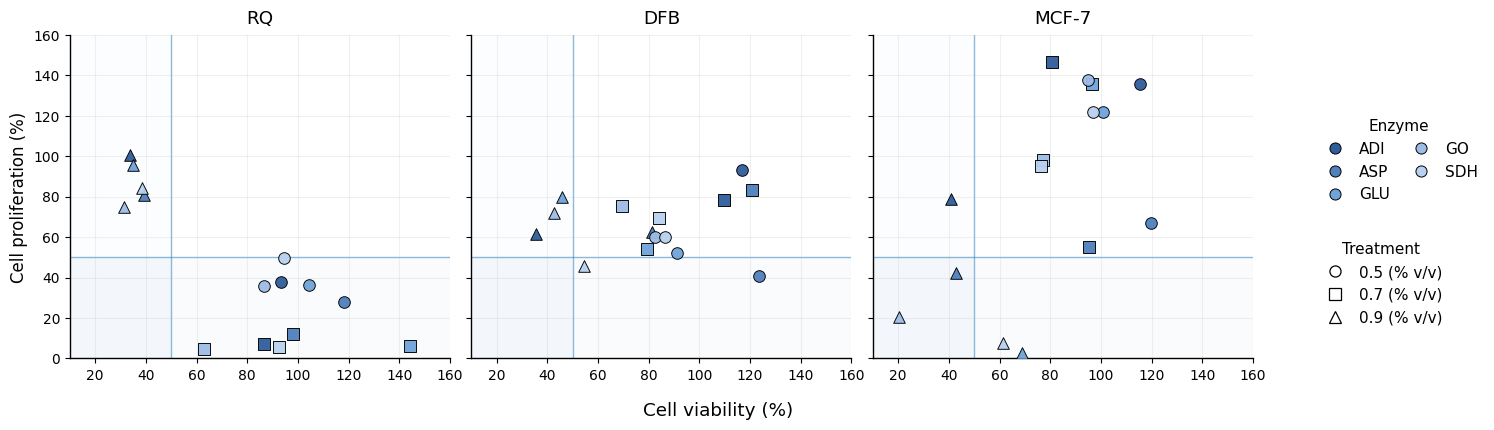

In [29]:
# ============================================================
# Scatter (Viability vs Proliferation) — faceted by Cell line
# Color = Enzyme | Marker = Treatment | Quadrant shading + right legends
# ============================================================

# Orders
cell_order = ["RQ", "DFB", "MCF-7"]
enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]
treat_order = [0.5, 0.7, 0.9]

# Color palette (blue family, consistent with your previous figures)
enzyme_blue = {
    "ADI": "#2F5D9B",
    "ASP": "#4F81BD",
    "GLU": "#6FA3D9",
    "GO":  "#9DBCE6",
    "SDH": "#B9D1F0",
}

# Marker shapes for treatment
treat_marker = {0.5: "o", 0.7: "s", 0.9: "^"}

# Quadrant thresholds (purely visual guides; not statistical)
thr_viability = 50
thr_prolif = 50

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
})

# Global axis limits
x_min = max(0, np.floor(df_vp["Viability"].min() / 10) * 10 - 10)
x_max = np.ceil(df_vp["Viability"].max() / 10) * 10 + 10
y_min = max(0, np.floor(df_vp["Proliferation"].min() / 10) * 10 - 10)
y_max = np.ceil(df_vp["Proliferation"].max() / 10) * 10 + 10

# --- Figure layout with space for legends
fig, axes = plt.subplots(1, 3, figsize=(14.5, 4.4), sharex=True, sharey=True)
axes = np.atleast_1d(axes)

# Subtle quadrant shading (very light)
shade_ll = "#EAF2FB"  # low-low
shade_lr = "#F2F6FB"  # high viability, low proliferation
shade_ul = "#F7F9FC"  # low viability, high proliferation

for ax, cl in zip(axes, cell_order):
    dcl = df_vp[df_vp["CellLine"] == cl].copy()

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Quadrant shading
    ax.axvspan(x_min, thr_viability, ymin=0, ymax=(thr_prolif - y_min) / (y_max - y_min),
               facecolor=shade_ll, alpha=0.55, zorder=0)
    ax.axvspan(thr_viability, x_max, ymin=0, ymax=(thr_prolif - y_min) / (y_max - y_min),
               facecolor=shade_lr, alpha=0.40, zorder=0)
    ax.axvspan(x_min, thr_viability, ymin=(thr_prolif - y_min) / (y_max - y_min), ymax=1,
               facecolor=shade_ul, alpha=0.25, zorder=0)

    # Reference lines
    ax.axvline(thr_viability, linewidth=1.0, alpha=0.50, zorder=1)
    ax.axhline(thr_prolif, linewidth=1.0, alpha=0.50, zorder=1)

    # Points
    for enz in enzyme_order:
        denz = dcl[dcl["Enzyme"] == enz]
        if denz.empty:
            continue

        for t in treat_order:
            dt = denz[denz["Treatment"] == t]
            if dt.empty:
                continue

            ax.scatter(
                dt["Viability"].values,
                dt["Proliferation"].values,
                s=70,
                marker=treat_marker[t],
                facecolor=enzyme_blue.get(enz, "#4F81BD"),
                edgecolor="black",
                linewidth=0.7,
                alpha=0.95,
                zorder=3
            )

    ax.set_title(cl, pad=8)
    ax.grid(alpha=0.18, linewidth=0.8, zorder=2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Shared labels
fig.supxlabel("Cell viability (%)", y=0.03)
axes[0].set_ylabel("Cell proliferation (%)")

# --- Legends on the right (columns)
enzyme_handles = [
    Line2D([0], [0],
           marker="o", linestyle="None",
           markerfacecolor=enzyme_blue[e],
           markeredgecolor="black",
           markeredgewidth=0.7,
           markersize=8,
           label=e)
    for e in enzyme_order if e in set(df_vp["Enzyme"])
]

treat_handles = [
    Line2D([0], [0],
           marker=treat_marker[t], linestyle="None",
           markerfacecolor="white",
           markeredgecolor="black",
           markeredgewidth=0.9,
           markersize=8,
           label=f"{t:g} (% v/v)")
    for t in treat_order if t in set(df_vp["Treatment"])
]

fig.legend(
    handles=enzyme_handles,
    title="Enzyme",
    loc="center left",
    bbox_to_anchor=(0.905, 0.62),
    ncol=2,
    frameon=False,
    columnspacing=1.0,
    handletextpad=0.6
)

fig.legend(
    handles=treat_handles,
    title="Treatment",
    loc="center left",
    bbox_to_anchor=(0.905, 0.34),
    ncol=1,
    frameon=False,
    handletextpad=0.6
)

# Leave space for legends
plt.tight_layout(rect=[0.0, 0.0, 0.88, 1.0])
plt.show()

### **Figure 8 – Relationship between cell viability and proliferation across enzymes, treatments, and cell lines**

Scatter plot visualization of cell viability versus cell proliferation reveals pronounced cell line–specific response landscapes and highlights substantial heterogeneity in enzyme- and dose-dependent effects. In RQ cells, the majority of conditions cluster in regions of moderate to high viability coupled with low proliferation, particularly at 0.5 and 0.7% (v/v), whereas several conditions at 0.9% (v/v) shift toward lower viability but higher proliferation, indicating a decoupling between these two response dimensions. In DFB cells, responses are more evenly distributed across the viability–proliferation space, with multiple conditions occupying the high-viability and moderate-to-high proliferation quadrant, and fewer extreme low-proliferation states, suggesting a more balanced modulation of both variables. In contrast, MCF-7 cells display a striking polarization, with several conditions exhibiting very high viability and proliferation at 0.5 and 0.7% (v/v), followed by a sharp transition toward low proliferation at 0.9% (v/v), particularly for GLU, GO, and SDH. Notably, enzyme-specific patterns are evident within each cell line, and treatment level contributes to systematic shifts within the scatter space rather than uniform directional changes. Overall, these distributions underscore a complex, non-linear relationship between viability and proliferation that is strongly dependent on both cellular context and enzyme identity, with clear evidence of context-specific coupling and decoupling across experimental conditions.


Global Pearson r = -0.011, p = 9.437e-01


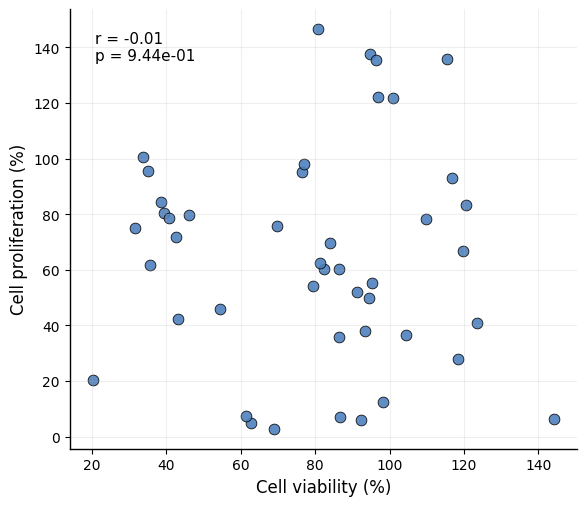

In [31]:
# ============================================================
# CORE 6.1 — Global correlation: Viability vs Proliferation
# ============================================================

x = df_vp["Viability"].values
y = df_vp["Proliferation"].values

r, p = pearsonr(x, y)
print(f"Global Pearson r = {r:.3f}, p = {p:.3e}")

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
})

fig, ax = plt.subplots(figsize=(6.0, 5.2))

ax.scatter(x, y, s=60, color="#4F81BD", edgecolor="black", linewidth=0.6, alpha=0.9)

ax.set_xlabel("Cell viability (%)")
ax.set_ylabel("Cell proliferation (%)")

ax.text(0.05, 0.95, f"r = {r:.2f}\np = {p:.2e}",
        transform=ax.transAxes, ha="left", va="top", fontsize=11)

ax.grid(alpha=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


### **Figure R – Global correlation between cell viability and proliferation**

Global correlation analysis reveals no significant linear association between cell viability and cell proliferation across all experimental conditions (Pearson r = −0.01, p = 0.94). The broad dispersion of data points across the viability–proliferation space, with high proliferation observed at both low and high viability levels, indicates a substantial decoupling between these two response variables. This lack of correlation suggests that viability and proliferation are modulated independently under the tested conditions, rather than following a simple coupled or proportional relationship.


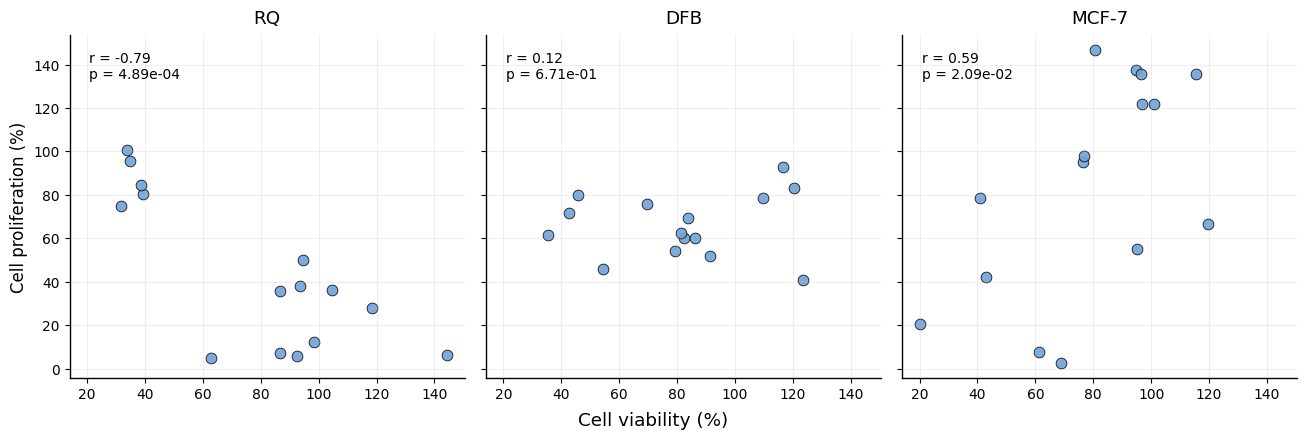

In [32]:
# ============================================================
# CORE 6.2 — Correlation by Cell line
# ============================================================

cell_order = ["RQ", "DFB", "MCF-7"]

fig, axes = plt.subplots(1, 3, figsize=(13.2, 4.6), sharex=True, sharey=True)
axes = np.atleast_1d(axes)

for ax, cl in zip(axes, cell_order):
    d = df_vp[df_vp["CellLine"] == cl]

    r, p = pearsonr(d["Viability"], d["Proliferation"])

    ax.scatter(d["Viability"], d["Proliferation"],
               s=60, color="#6FA3D9", edgecolor="black", linewidth=0.6, alpha=0.9)

    ax.set_title(cl, pad=8)
    ax.text(0.05, 0.95, f"r = {r:.2f}\np = {p:.2e}",
            transform=ax.transAxes, ha="left", va="top", fontsize=10)

    ax.grid(alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Cell proliferation (%)")
fig.supxlabel("Cell viability (%)", y=0.05)

plt.tight_layout()
plt.show()


### **Figure Q – Cell line–specific correlation between cell viability and proliferation**

Cell line–stratified correlation analysis reveals markedly divergent relationships between viability and proliferation across cellular contexts. In RQ cells, a strong and significant negative correlation is observed (r = −0.79, p = 4.89 × 10⁻⁴), indicating that conditions associated with higher viability tend to exhibit lower proliferation and vice versa, consistent with a pronounced decoupling of these response dimensions. In contrast, DFB cells show no significant association between viability and proliferation (r = 0.12, p = 0.67), with data points broadly dispersed across the response space, suggesting independent modulation of the two variables. In MCF-7 cells, a moderate and significant positive correlation is detected (r = 0.59, p = 2.09 × 10⁻²), indicating partial coupling between viability and proliferation under these conditions. Together, these patterns highlight strong cell line–specific differences in the relationship between viability and proliferative responses, underscoring the importance of cellular context in shaping enzyme- and dose-dependent effects.


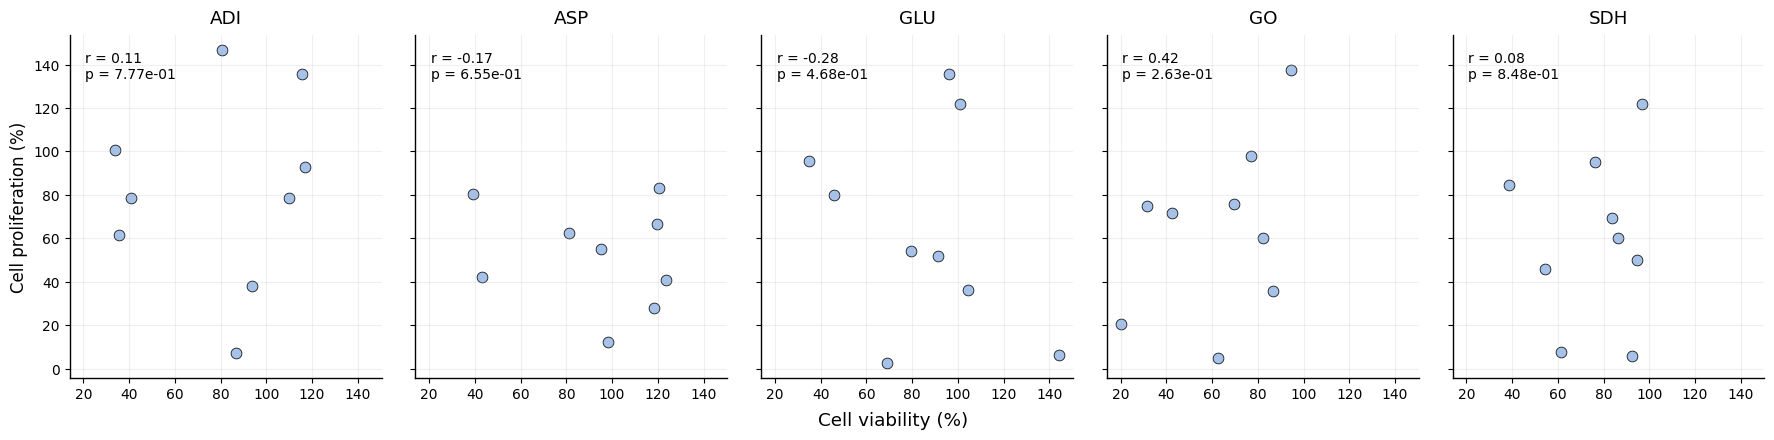

In [33]:
# ============================================================
# CORE 6.3 — Correlation by Enzyme
# ============================================================

enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]

fig, axes = plt.subplots(1, 5, figsize=(18.0, 4.6), sharex=True, sharey=True)
axes = np.atleast_1d(axes)

for ax, enz in zip(axes, enzyme_order):
    d = df_vp[df_vp["Enzyme"] == enz]

    r, p = pearsonr(d["Viability"], d["Proliferation"])

    ax.scatter(d["Viability"], d["Proliferation"],
               s=60, color="#9DBCE6", edgecolor="black", linewidth=0.6, alpha=0.9)

    ax.set_title(enz, pad=8)
    ax.text(0.05, 0.95, f"r = {r:.2f}\np = {p:.2e}",
            transform=ax.transAxes, ha="left", va="top", fontsize=10)

    ax.grid(alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Cell proliferation (%)")
fig.supxlabel("Cell viability (%)", y=0.05)

plt.tight_layout()
plt.show()

### **Figure P – Enzyme-specific correlation between cell viability and proliferation**

Enzyme-stratified correlation analysis reveals weak and non-significant associations between cell viability and proliferation for all enzymes tested. ADI and SDH show near-zero correlations (r = 0.11 and r = 0.08, respectively), indicating minimal coupling between viability and proliferation across conditions. ASP and GLU display weak negative trends (r = −0.17 and r = −0.28, respectively), whereas GO shows a moderate positive trend (r = 0.42); however, none of these associations reach statistical significance (all p > 0.05). The broad dispersion of data points within each enzyme-specific scatter plot indicates substantial heterogeneity across cell lines and treatment levels. These results suggest that, at the level of individual enzymes, viability and proliferation are not consistently coupled and that the relationship between these two response variables is primarily shaped by cellular context rather than by enzyme identity alone.

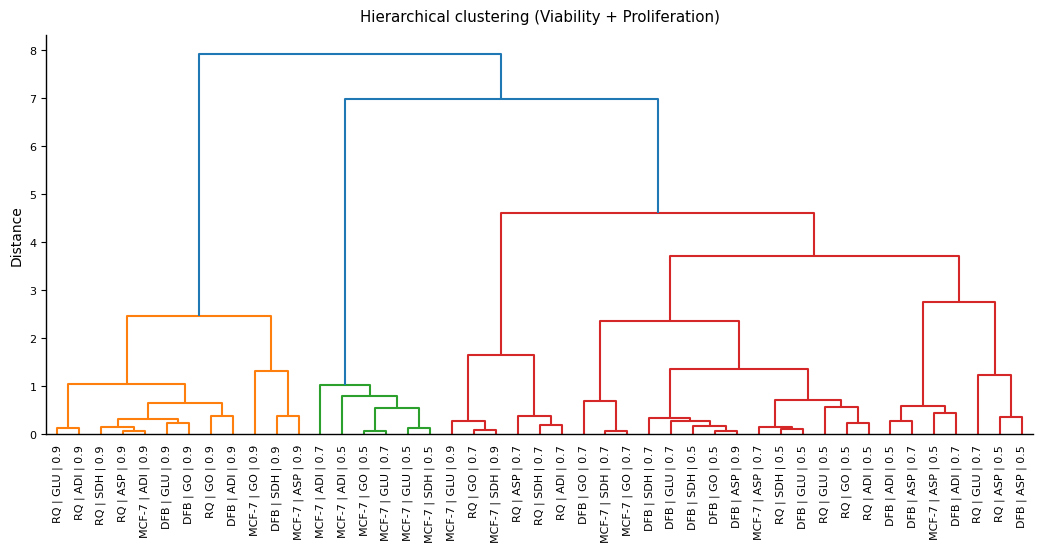

In [35]:
# ============================================================
# CORE 7.1 — Hierarchical clustering dendrogram
# Features: Viability + Proliferation
# ============================================================

# Build feature matrix
X = df_vp[["Viability", "Proliferation"]].values
labels = (
    df_vp["CellLine"] + " | " +
    df_vp["Enzyme"] + " | " +
    df_vp["Treatment"].astype(str)
).values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Linkage (Ward = good default for continuous data)
Z = linkage(X_scaled, method="ward")

plt.rcParams.update({
    "font.size": 9,
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.linewidth": 1.0,
})

fig, ax = plt.subplots(figsize=(10.5, 5.6))

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=None
)

ax.set_title("Hierarchical clustering (Viability + Proliferation)", pad=10)
ax.set_ylabel("Distance")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


### **Figure O – Hierarchical clustering of experimental conditions based on combined viability and proliferation profiles**

Hierarchical clustering based on combined cell viability and proliferation profiles reveals a structured and non-random organization of experimental conditions, highlighting distinct response regimes across enzymes, treatment levels, and cell lines. The dendrogram shows clear separation between clusters characterized by low viability–low proliferation profiles and those exhibiting higher combined responses, indicating that global response magnitude is a primary driver of clustering. Several subclusters group conditions with similar treatment levels, particularly at 0.9% (v/v), which tend to segregate from lower-dose conditions, reflecting strong dose-dependent effects. Within these broad groupings, additional stratification by cell line is observed, with multiple MCF-7 conditions clustering together, consistent with the distinctive response patterns identified in the PCA and scatter analyses. Enzyme-specific grouping is also evident in selected branches, suggesting that certain enzymes induce characteristic viability–proliferation signatures across contexts. Importantly, clustering is not exclusively determined by any single factor, and mixed branches containing different enzymes and cell lines indicate that combined response profiles emerge from the interaction of enzyme identity, treatment level, and cellular context. Overall, the hierarchical structure underscores the multidimensional and context-dependent nature of enzyme-mediated effects on cell viability and proliferation.

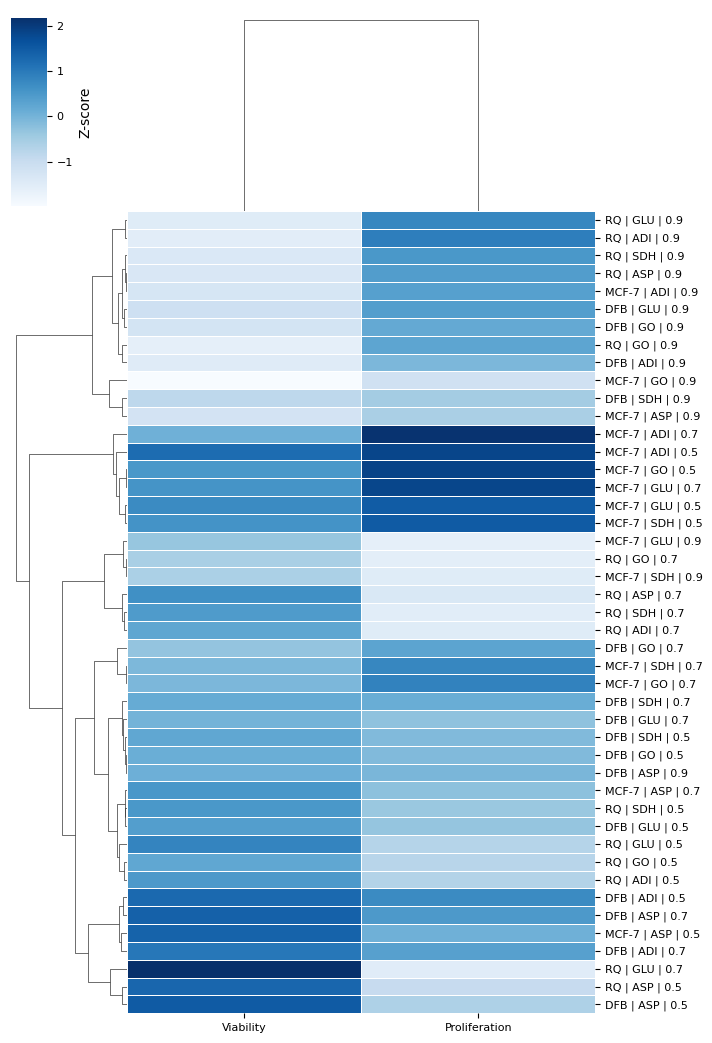

In [37]:
# ============================================================
# CORE 7.2 — Clustered heatmap (Viability + Proliferation)
# ============================================================

# Create dataframe for heatmap
df_feat = df_vp[["Viability", "Proliferation"]].copy()
df_feat.index = labels  # reuse labels from above

# Standardize again for heatmap
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_feat),
    index=df_feat.index,
    columns=df_feat.columns
)

plt.rcParams.update({
    "font.size": 9,
    "axes.labelsize": 10,
})

# Seaborn clustermap (hierarchical clustering)
cg = sns.clustermap(
    df_scaled,
    method="ward",
    metric="euclidean",
    cmap="Blues",
    linewidths=0.5,
    figsize=(7.2, 10.5),
    cbar_kws={"label": "Z-score"}
)

plt.show()

### **Figure N – Clustered heatmap of combined viability and proliferation profiles across experimental conditions**

The clustered heatmap based on standardized viability and proliferation values reveals distinct response regimes across the full set of experimental conditions, highlighting non-random structure in the combined response space. Several clusters are characterized by high viability coupled with high proliferation, predominantly enriched in MCF-7 conditions at 0.5 and 0.7% (v/v), consistent with the elevated responses observed in earlier univariate and bivariate analyses. In contrast, a separate set of clusters groups conditions with low proliferation and moderate-to-high viability, largely corresponding to RQ and DFB samples at intermediate doses, reflecting a decoupling between these two response dimensions. High-dose conditions (0.9% v/v) frequently segregate into distinct branches, often associated with reduced viability and variable proliferation, underscoring the strong dose-dependent effects identified in dose–response and delta analyses. Enzyme-specific tendencies are also evident within subclusters, with certain enzymes repeatedly co-localizing across different cell lines, suggesting characteristic combined response signatures. Importantly, clustering is not strictly driven by any single factor, and mixed branches containing different enzymes, cell lines, and treatment levels indicate that the observed patterns emerge from the interaction of enzyme identity, dose, and cellular context. Overall, this clustered representation reinforces the multidimensional and context-dependent nature of enzyme-mediated modulation of viability and proliferation.


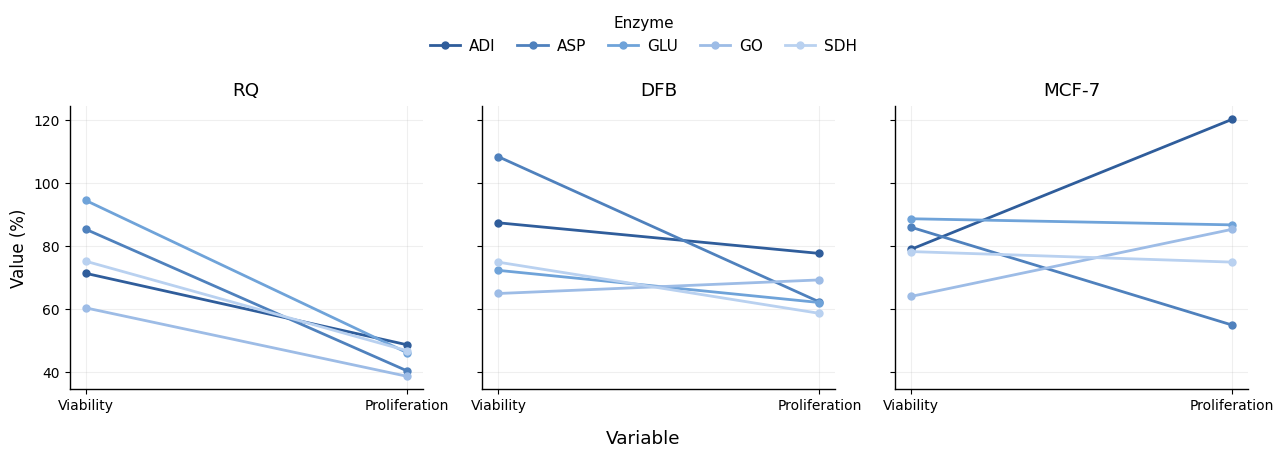

In [38]:
# ============================================================
# CORE 8.1 — Profile (fingerprint) plots by Cell line
# Each enzyme = one line, variables = Viability & Proliferation
# Values = mean across treatments (purely descriptive)
# ============================================================

cell_order = ["RQ", "DFB", "MCF-7"]
enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]
variables = ["Viability", "Proliferation"]

# Color palette (same blue family)
enzyme_blue = {
    "ADI": "#2F5D9B",
    "ASP": "#4F81BD",
    "GLU": "#6FA3D9",
    "GO":  "#9DBCE6",
    "SDH": "#B9D1F0",
}

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
})

fig, axes = plt.subplots(1, 3, figsize=(13.0, 4.2), sharey=True)
axes = np.atleast_1d(axes)

for ax, cl in zip(axes, cell_order):
    dcl = df_vp[df_vp["CellLine"] == cl]

    # Mean per enzyme (across treatments)
    summary = (
        dcl.groupby("Enzyme")[variables]
           .mean()
           .reindex(enzyme_order)
    )

    x = np.arange(len(variables))

    for enz in enzyme_order:
        vals = summary.loc[enz].values

        ax.plot(
            x, vals,
            marker="o",
            linewidth=2.0,
            markersize=5,
            color=enzyme_blue[enz],
            label=enz
        )

    ax.set_title(cl, pad=8)
    ax.set_xticks(x)
    ax.set_xticklabels(variables)
    ax.grid(alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Value (%)")
fig.supxlabel("Variable", y=0.04)

# Legend (shared)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Enzyme",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=5,
    frameon=False,
    columnspacing=1.4,
    handletextpad=0.6
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### **Figure M – Enzyme-specific response fingerprints of viability and proliferation across cell lines**

Fingerprint profiles reveal distinct enzyme-specific response patterns across the three cell lines, highlighting marked differences in the balance between viability and proliferation. In RQ cells, all enzymes display higher viability than proliferation, with pronounced drops in proliferation for ASP, GLU, and SDH, indicating a general trend toward reduced proliferative activity despite moderate viability levels. In DFB cells, fingerprints are more compact and homogeneous, with smaller separations between viability and proliferation for most enzymes, suggesting a more balanced modulation of these two response dimensions. In contrast, MCF-7 cells exhibit strongly divergent fingerprints, characterized by elevated proliferation relative to viability for ADI and GLU, while ASP shows a pronounced decrease in proliferation despite high viability. GO and SDH in MCF-7 display intermediate patterns, with moderate separation between the two variables. Notably, the shape and orientation of the fingerprints differ substantially between cell lines, indicating that enzyme-mediated effects are strongly context-dependent and that the relative coupling or decoupling of viability and proliferation is a defining feature of each cellular response landscape.

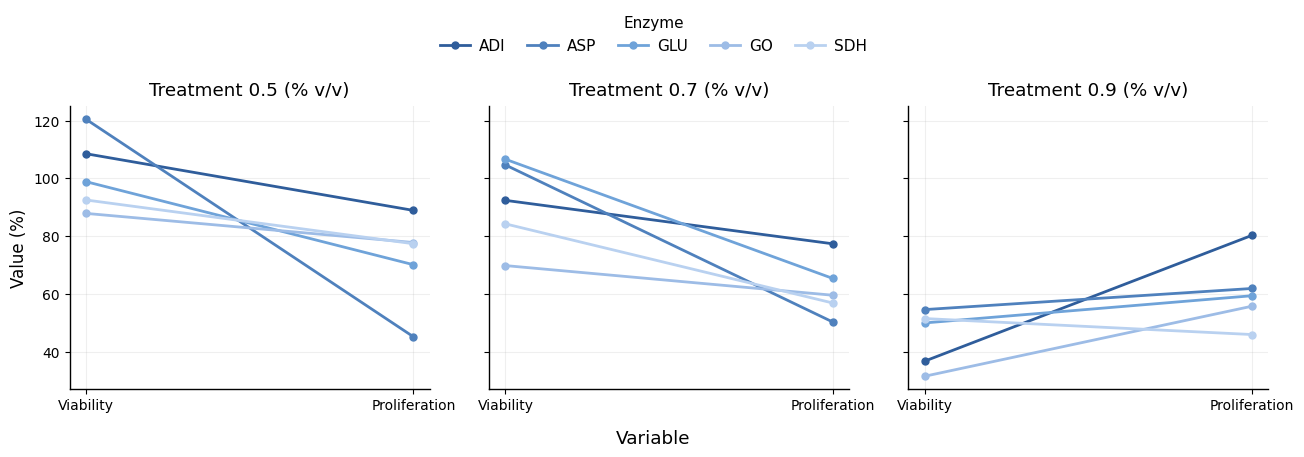

In [39]:
# ============================================================
# CORE 8.2 — Profile plots by Treatment (fingerprints)
# Each panel = one Treatment
# Each line = one Enzyme
# Values = mean across Cell lines (purely descriptive)
# ============================================================

treat_order = [0.5, 0.7, 0.9]
enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]
variables = ["Viability", "Proliferation"]

# Color palette (same blue family)
enzyme_blue = {
    "ADI": "#2F5D9B",
    "ASP": "#4F81BD",
    "GLU": "#6FA3D9",
    "GO":  "#9DBCE6",
    "SDH": "#B9D1F0",
}

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
})

fig, axes = plt.subplots(1, 3, figsize=(13.2, 4.2), sharey=True)
axes = np.atleast_1d(axes)

for ax, t in zip(axes, treat_order):
    dt = df_vp[df_vp["Treatment"] == t]

    # Mean per enzyme across cell lines
    summary = (
        dt.groupby("Enzyme")[variables]
          .mean()
          .reindex(enzyme_order)
    )

    x = np.arange(len(variables))

    for enz in enzyme_order:
        vals = summary.loc[enz].values

        ax.plot(
            x, vals,
            marker="o",
            linewidth=2.0,
            markersize=5,
            color=enzyme_blue[enz],
            label=enz
        )

    ax.set_title(f"Treatment {t:g} (% v/v)", pad=8)
    ax.set_xticks(x)
    ax.set_xticklabels(variables)
    ax.grid(alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Value (%)")
fig.supxlabel("Variable", y=0.04)

# Legend (shared)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Enzyme",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=5,
    frameon=False,
    columnspacing=1.4,
    handletextpad=0.6
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### **Figure L – Dose-specific enzyme fingerprints of viability and proliferation**

Dose-stratified fingerprint profiles reveal systematic and progressive shifts in the balance between viability and proliferation across treatment levels. At 0.5% (v/v), most enzymes exhibit higher viability than proliferation, with pronounced separations for ASP and GLU, indicating strong suppression of proliferative activity despite preserved viability. At 0.7% (v/v), fingerprints become more compressed, reflecting partial convergence between viability and proliferation across enzymes, suggesting a transition toward more balanced modulation of both response dimensions. In contrast, at 0.9% (v/v), fingerprints invert for several enzymes, particularly ADI and GLU, with proliferation exceeding viability, indicating a qualitative change in response behavior at higher doses. GO and SDH show more moderate shifts across doses, maintaining relatively stable profiles. Overall, these patterns highlight a clear dose-dependent reorganization of enzyme-specific response fingerprints, with low and intermediate doses favoring viability-dominant profiles and high doses associated with increased proliferative dominance for selected enzymes.


In [40]:
# ============================================================
# CORE 9 — Delta analysis (0.9 - 0.5)
# ΔViability and ΔProliferation by Cell line and Enzyme
# ============================================================

cell_order = ["RQ", "DFB", "MCF-7"]
enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]

# Pivot to get 0.5 and 0.9 side by side
pivot = df_vp.pivot_table(
    index=["CellLine", "Enzyme"],
    columns="Treatment",
    values=["Viability", "Proliferation"]
)

# Compute deltas
delta_df = pd.DataFrame({
    "Delta_Viability": pivot["Viability"][0.9] - pivot["Viability"][0.5],
    "Delta_Proliferation": pivot["Proliferation"][0.9] - pivot["Proliferation"][0.5],
}).reset_index()

print(delta_df.head())


  CellLine Enzyme  Delta_Viability  Delta_Proliferation
0      DFB    ADI       -81.185547           -31.352459
1      DFB    ASP       -42.231194            21.926230
2      DFB    GLU       -45.402407            27.766393
3      DFB     GO       -39.825204            11.680328
4      DFB    SDH       -31.971112           -14.446721


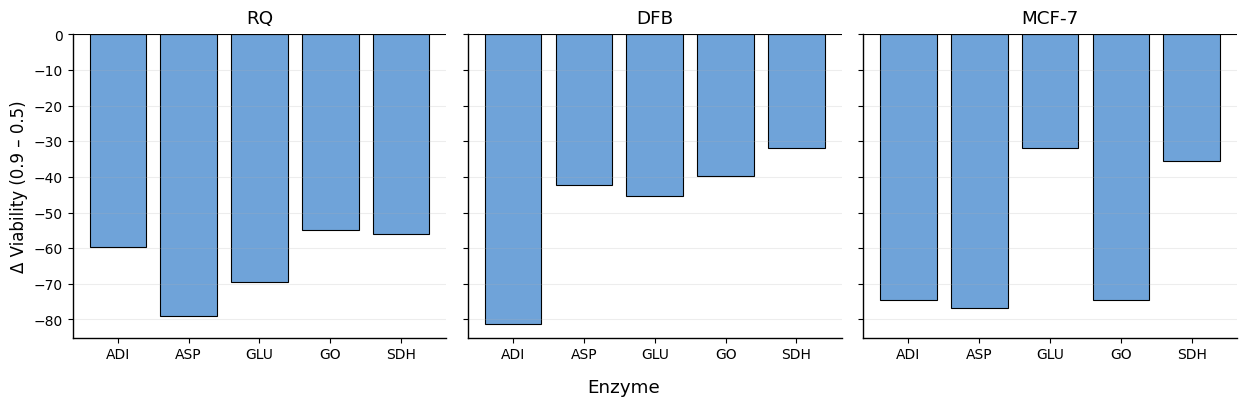

In [41]:
# ============================================================
# Plot ΔViability by Enzyme, faceted by Cell line
# ============================================================

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
})

fig, axes = plt.subplots(1, 3, figsize=(12.6, 4.2), sharey=True)
axes = np.atleast_1d(axes)

x = np.arange(len(enzyme_order))

for ax, cl in zip(axes, cell_order):
    dcl = delta_df[delta_df["CellLine"] == cl].set_index("Enzyme").reindex(enzyme_order)

    ax.bar(
        x, dcl["Delta_Viability"].values,
        color="#6FA3D9",
        edgecolor="black",
        linewidth=0.8
    )

    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_title(cl, pad=8)
    ax.set_xticks(x)
    ax.set_xticklabels(enzyme_order)
    ax.grid(axis="y", alpha=0.22, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Δ Viability (0.9 – 0.5)")
fig.supxlabel("Enzyme", y=0.04)

plt.tight_layout()
plt.show()

### **Figure K – Dose-induced changes in cell viability (Δ viability, 0.9% – 0.5%) across enzymes and cell lines**

Delta analysis of cell viability reveals a consistent and pronounced reduction in viability at 0.9% (v/v) relative to 0.5% (v/v) across all enzymes and cell lines. In RQ cells, all enzymes exhibit substantial negative shifts, with the strongest decreases observed for ASP and GLU, indicating high sensitivity to dose escalation. DFB cells show a similar pattern, with ADI displaying the most pronounced reduction, while ASP, GLU, and GO exhibit moderate but consistent declines. In MCF-7 cells, marked decreases are also observed across all enzymes, particularly for ADI, ASP, and GO, whereas GLU and SDH show comparatively smaller but still notable reductions. The uniform directionality of the delta values across enzymes and cell lines underscores a conserved dose-dependent inhibitory effect on viability, while the magnitude of the decreases highlights cell line–specific sensitivity profiles. Overall, these results demonstrate that increasing the treatment concentration from 0.5 to 0.9% (v/v) is associated with a robust and systematic loss of viability, with differential intensity depending on both enzyme identity and cellular context.

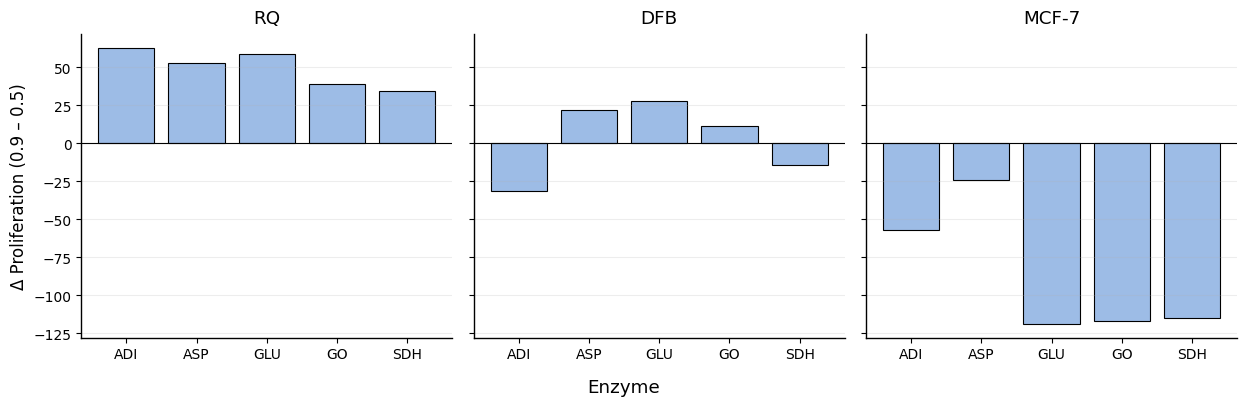

In [42]:
# ============================================================
# Plot ΔProliferation by Enzyme, faceted by Cell line
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(12.6, 4.2), sharey=True)
axes = np.atleast_1d(axes)

for ax, cl in zip(axes, cell_order):
    dcl = delta_df[delta_df["CellLine"] == cl].set_index("Enzyme").reindex(enzyme_order)

    ax.bar(
        x, dcl["Delta_Proliferation"].values,
        color="#9DBCE6",
        edgecolor="black",
        linewidth=0.8
    )

    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_title(cl, pad=8)
    ax.set_xticks(x)
    ax.set_xticklabels(enzyme_order)
    ax.grid(axis="y", alpha=0.22, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Δ Proliferation (0.9 – 0.5)")
fig.supxlabel("Enzyme", y=0.04)

plt.tight_layout()
plt.show()

### **Figure J – Dose-induced changes in cell proliferation (Δ proliferation, 0.9% – 0.5%) across enzymes and cell lines**

Delta analysis of cell proliferation reveals strong and divergent dose-dependent responses across cell lines. In RQ cells, all enzymes exhibit marked positive shifts in proliferation when increasing the treatment from 0.5 to 0.9% (v/v), with particularly pronounced increases for ADI, ASP, and GLU, indicating a robust proliferative response at higher doses. In contrast, DFB cells display a more heterogeneous pattern, with moderate increases in proliferation for ASP, GLU, and GO, but a decrease for ADI and SDH, suggesting enzyme-specific modulation of proliferative activity. Strikingly, MCF-7 cells show a uniform and pronounced decrease in proliferation across all enzymes at 0.9% (v/v), with the strongest reductions observed for GLU, GO, and SDH, indicating high sensitivity of this cell line to dose escalation in terms of proliferative capacity. Together, these results demonstrate that the impact of increasing treatment concentration on proliferation is highly cell line–dependent and can be directionally opposite across contexts, highlighting a fundamental divergence in proliferative control mechanisms between RQ, DFB, and MCF-7 cells.


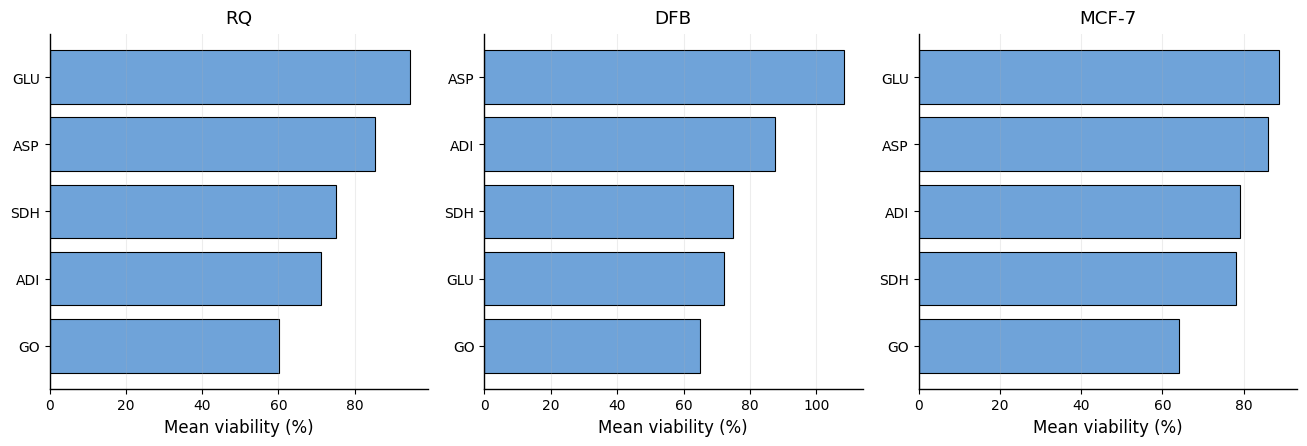

In [43]:
# ============================================================
# CORE 10A — Ranking by Viability (per Cell line)
# ============================================================

cell_order = ["RQ", "DFB", "MCF-7"]
enzyme_order = ["ADI", "ASP", "GLU", "GO", "SDH"]

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
})

fig, axes = plt.subplots(1, 3, figsize=(13.2, 4.6), sharex=False)
axes = np.atleast_1d(axes)

for ax, cl in zip(axes, cell_order):
    dcl = df_vp[df_vp["CellLine"] == cl]

    # Mean viability per enzyme (across treatments)
    rank_df = (
        dcl.groupby("Enzyme")["Viability"]
           .mean()
           .sort_values(ascending=False)
    )

    ax.barh(
        rank_df.index,
        rank_df.values,
        color="#6FA3D9",
        edgecolor="black",
        linewidth=0.8
    )

    ax.set_title(cl, pad=8)
    ax.set_xlabel("Mean viability (%)")
    ax.invert_yaxis()  # highest on top
    ax.grid(axis="x", alpha=0.22, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

### **Figure I – Enzyme ranking based on mean cell viability across cell lines**

Ranking enzymes by mean cell viability reveals distinct and cell line–dependent viability profiles. In RQ cells, GLU and ASP rank highest, indicating superior preservation of viability, whereas GO consistently shows the lowest mean viability, suggesting a stronger detrimental effect in this cellular context. In DFB cells, ASP and ADI emerge as the top-ranked enzymes, followed by SDH and GLU, with GO again displaying the lowest mean viability. In MCF-7 cells, GLU and ASP maintain the highest rankings, closely followed by ADI and SDH, while GO remains the least favorable enzyme in terms of viability. Despite differences in absolute ranking order across cell lines, a consistent pattern emerges in which GLU and ASP tend to occupy higher viability ranks, whereas GO systematically ranks lowest. These results highlight enzyme-specific tendencies in maintaining cell viability while underscoring the importance of cellular context in modulating the relative impact of each enzyme.

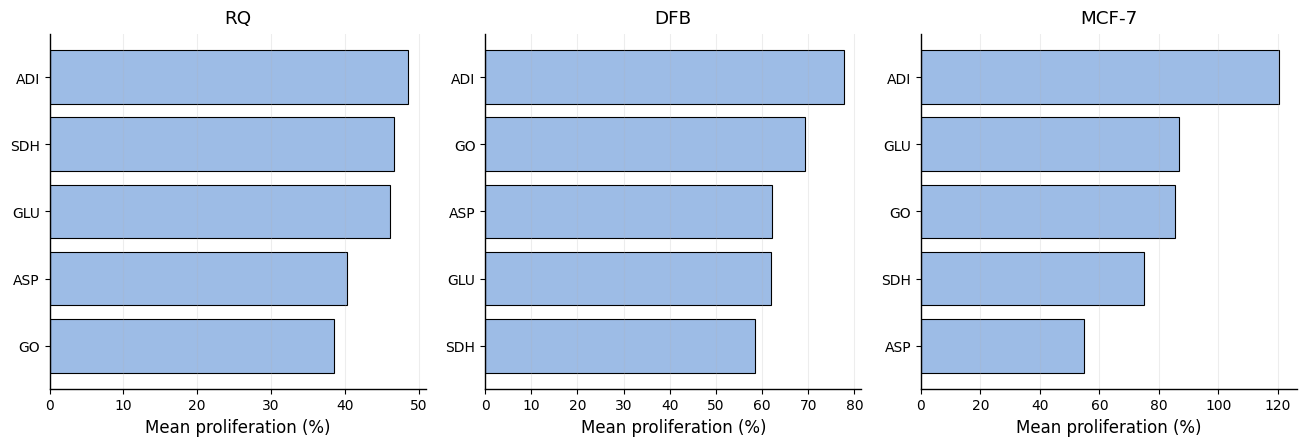

In [44]:
# ============================================================
# CORE 10B — Ranking by Proliferation (per Cell line)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(13.2, 4.6), sharex=False)
axes = np.atleast_1d(axes)

for ax, cl in zip(axes, cell_order):
    dcl = df_vp[df_vp["CellLine"] == cl]

    # Mean proliferation per enzyme (across treatments)
    rank_df = (
        dcl.groupby("Enzyme")["Proliferation"]
           .mean()
           .sort_values(ascending=False)
    )

    ax.barh(
        rank_df.index,
        rank_df.values,
        color="#9DBCE6",
        edgecolor="black",
        linewidth=0.8
    )

    ax.set_title(cl, pad=8)
    ax.set_xlabel("Mean proliferation (%)")
    ax.invert_yaxis()
    ax.grid(axis="x", alpha=0.22, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


### **Figure H – Enzyme ranking based on mean cell proliferation across cell lines**

Ranking enzymes by mean cell proliferation reveals pronounced cell line–specific differences and patterns that contrast with those observed for viability. In RQ cells, ADI, SDH, and GLU rank highest in terms of proliferative response, whereas ASP and GO display comparatively lower proliferation, indicating selective enhancement of proliferative capacity depending on enzyme identity. In DFB cells, ADI and GO occupy the top ranks, followed by ASP and GLU, while SDH shows the lowest mean proliferation, reflecting a more heterogeneous and enzyme-dependent proliferative landscape. In MCF-7 cells, ADI clearly dominates the ranking, exhibiting the highest mean proliferation by a substantial margin, followed by GLU and GO, whereas ASP and SDH rank lowest. Notably, enzymes that rank highly in viability do not necessarily rank highly in proliferation, particularly in MCF-7 cells, underscoring a clear decoupling between these two biological response dimensions. Overall, these rankings highlight that proliferative outcomes are strongly shaped by both enzyme identity and cellular context, reinforcing the need to consider viability and proliferation as distinct and complementary endpoints.

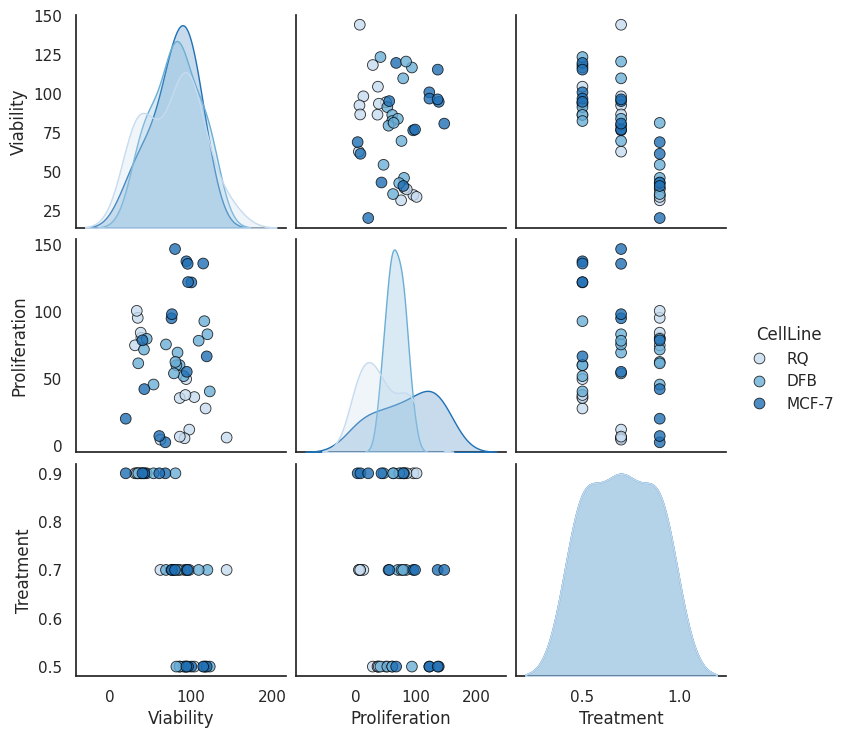

In [46]:
# ============================================================
# CORE 11 — Pairplot: Viability, Proliferation, Treatment
# ============================================================

sns.set(style="white", context="notebook")

pair_df = df_vp[["Viability", "Proliferation", "Treatment", "CellLine", "Enzyme"]].copy()

g = sns.pairplot(
    pair_df,
    vars=["Viability", "Proliferation", "Treatment"],
    hue="CellLine",
    palette="Blues",
    plot_kws={"alpha": 0.8, "s": 60, "edgecolor": "black"},
    diag_kind="kde"
)

plt.show()

### **Figure G – Pairwise relationships between viability, proliferation, and treatment across cell lines**

The pairwise visualization of viability, proliferation, and treatment levels highlights the complex and non-linear relationships among these variables across cell lines. Marginal density distributions indicate broad and partially overlapping ranges of viability and proliferation, with MCF-7 samples extending toward higher proliferation values, consistent with earlier univariate and ranking analyses. Scatter plots confirm the absence of a strong global linear association between viability and proliferation, while revealing substantial dispersion and cell line–specific clustering patterns. Treatment levels form discrete bands, reflecting the experimental design, and show clear stratification effects, particularly at higher concentrations where reduced viability and altered proliferation distributions become evident. Overall, this pairwise representation reinforces the decoupling between viability and proliferation observed in correlation and delta analyses, while illustrating how treatment concentration and cellular context jointly shape the multidimensional response landscape.

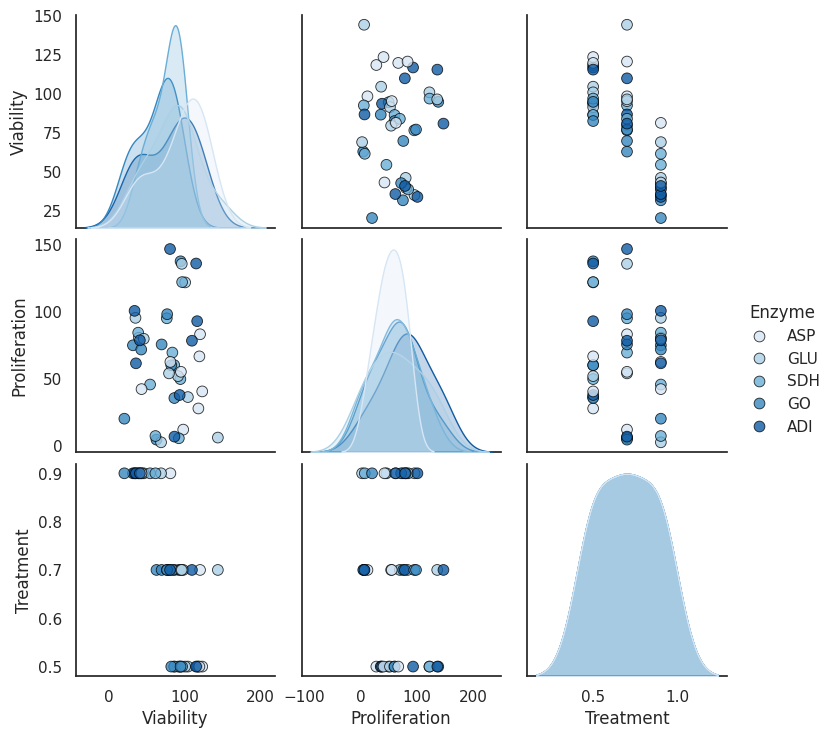

In [47]:
# ============================================================
# CORE 11.1 — Pairplot by Enzyme (faceted)
# ============================================================

g = sns.pairplot(
    pair_df,
    vars=["Viability", "Proliferation", "Treatment"],
    hue="Enzyme",
    palette="Blues",
    plot_kws={"alpha": 0.8, "s": 60, "edgecolor": "black"},
    diag_kind="kde"
)

plt.show()

### **Figure F – Pairwise relationships between viability, proliferation, and treatment stratified by enzyme**

Enzyme-stratified pairwise analysis reveals distinct distributional patterns in viability and proliferation that are not apparent in the aggregated view. Marginal density plots show enzyme-specific shifts in both viability and proliferation ranges, with ADI and GLU exhibiting broader distributions, particularly toward higher proliferation values, whereas GO and SDH display more constrained profiles. Scatter plots confirm substantial overlap between enzymes, yet reveal differences in dispersion and central tendency, suggesting heterogeneous response variability depending on enzyme identity. Treatment levels form discrete strata across all enzymes, reflecting the experimental design, and indicate that dose effects manifest as shifts in distribution rather than simple linear trends. Overall, this faceted representation emphasizes enzyme-dependent heterogeneity in the joint viability–proliferation space while reinforcing the absence of a universal response pattern across enzymes.

# **Methodological description – Exploratory and multivariate analysis of viability and proliferation data**

## **Data structure and preprocessing**

All analyses were performed using a structured dataset comprising measurements of cell viability and cell proliferation across multiple experimental conditions. The dataset includes three categorical factors: cell line (RQ, DFB, MCF-7), enzyme (ADI, ASP, GLU, GO, SDH), and treatment level (0.5, 0.7, and 0.9% v/v). For each unique combination of these factors, quantitative measurements of cell viability and proliferation were provided, resulting in a fully balanced design with 45 observations (3 cell lines × 5 enzymes × 3 treatment levels).

Prior to analysis, all variables were inspected for consistency, data types were standardized, and categorical labels were harmonized. Numerical columns corresponding to viability, proliferation, and treatment levels were explicitly cast to numeric formats. No imputation or transformation was applied, and all analyses were conducted directly on the observed values.

---

## **Univariate analysis**

To characterize enzyme-dependent response patterns, univariate summaries were generated for both cell viability and cell proliferation. Bar plots were constructed to display mean values per enzyme, stratified by cell line and colored by treatment level. These visualizations were intended to provide a direct overview of how each enzyme modulates viability and proliferation across different cellular contexts and doses.

No error bars or statistical significance testing were applied, as each condition is represented by a single observation. All univariate visualizations are therefore descriptive in nature.

---

## **Dose–response analysis**

Dose–response relationships were explored by plotting treatment level (0.5, 0.7, 0.9% v/v) against cell viability and cell proliferation for each enzyme, separately for each cell line. These analyses were implemented as line plots with markers, faceted by cell line and enzyme.

This approach enables visualization of monotonic, non-monotonic, or threshold-like trends in response to increasing treatment concentration, without assuming linearity or imposing parametric models.

---

## **Bivariate analysis: viability–proliferation relationships**

The relationship between cell viability and cell proliferation was examined using scatter plots, both globally and stratified by cell line. Points were encoded using color to represent enzyme identity and marker shape to represent treatment level. This allowed simultaneous visualization of multiple experimental factors within a single bivariate space.

In addition, quadrant-based visualizations were constructed using reference lines at predefined viability and proliferation thresholds. Subtle background shading was applied to delineate regions corresponding to high–high, low–low, and mixed response regimes. These quadrant plots serve as exploratory tools to assess potential decoupling or coupling between viability and proliferation across conditions.

---

## **Matrix-based analysis: heatmaps**

To provide a compact overview of response patterns, heatmaps were generated separately for cell viability and cell proliferation. For each cell line, a matrix was constructed with enzymes as rows and treatment levels as columns. Values were color-coded using a shared continuous scale to facilitate comparison across panels.

Heatmaps were annotated with numerical values and arranged in a single row layout to enable direct visual comparison between cell lines. These representations were used to identify global patterns, gradients, and enzyme-specific response signatures.

---

## **Multivariate analysis: principal component analysis (PCA)**

Principal component analysis was applied to the two-dimensional feature space defined by cell viability and cell proliferation. Prior to PCA, features were standardized to zero mean and unit variance. The first two principal components were retained and visualized in a scatter plot.

Points were encoded by enzyme (color), cell line (marker shape), and treatment level (marker size), enabling assessment of global structure, clustering tendencies, and factor-driven separation in the reduced space. PCA was used solely as an exploratory tool to reveal dominant variance patterns and was not employed for predictive modeling.

---

## **Correlation analysis**

Pairwise correlations between cell viability and cell proliferation were computed using Pearson’s correlation coefficient. Correlation analyses were conducted at three levels:

1. Global correlation across all observations
2. Stratified by cell line
3. Stratified by enzyme

Scatter plots were generated for each case, with correlation coefficients and associated p-values reported directly on the figures. These analyses were intended to assess the degree of coupling or decoupling between viability and proliferation under different experimental contexts.

---

## **Hierarchical clustering and structural analysis**

To explore the intrinsic structure of the dataset, hierarchical clustering was performed using standardized viability and proliferation values. Ward’s linkage method and Euclidean distance were used to construct the dendrogram.

In addition, clustered heatmaps were generated by reordering observations according to the hierarchical clustering results. This enabled visualization of groups of experimental conditions exhibiting similar combined viability–proliferation profiles, without imposing predefined groupings.

---

## **Profile (fingerprint) analysis**

Profile plots were generated to capture response “fingerprints” for each enzyme. Two complementary approaches were used:

1. **Cell line–specific profiles:**
   For each cell line, mean viability and proliferation values were computed per enzyme (averaged across treatment levels) and plotted as connected line profiles.

2. **Treatment-specific profiles:**
   For each treatment level, mean viability and proliferation values were computed per enzyme (averaged across cell lines) and plotted as line profiles.

These visualizations provide compact summaries of enzyme-specific response patterns across variables and experimental contexts.

---

## **Delta analysis (dose impact quantification)**

To quantify the magnitude of response changes with increasing dose, delta values were computed for each cell line–enzyme combination as:

* ΔViability = Viability(0.9) – Viability(0.5)
* ΔProliferation = Proliferation(0.9) – Proliferation(0.5)

These delta values were visualized using bar plots faceted by cell line. This analysis provides a direct measure of dose sensitivity and highlights enzymes exhibiting strong or weak changes across the tested concentration range.

---

## **Ranking analysis**

Ranking plots were generated to order enzymes according to their mean viability and mean proliferation values, separately for each cell line. Horizontal bar charts were used to display enzyme rankings from highest to lowest response.

This analysis enables straightforward comparison of relative enzyme performance within each cellular context.

---

## **Pairwise relationship analysis (pairplots)**

Finally, pairwise relationships among cell viability, cell proliferation, and treatment level were visualized using pair plots. Separate pair plots were generated with color encoding by cell line and by enzyme.

These plots provide a comprehensive overview of univariate distributions and bivariate relationships among all quantitative variables in the dataset.

---

## **Analytical scope and limitations**

All analyses were conducted in a purely descriptive and exploratory manner. No statistical hypothesis testing, confidence interval estimation, or inferential modeling was performed, as the dataset does not contain biological replicates for each condition. Consequently, all visualizations and numerical summaries are intended to reveal patterns and structure rather than to support formal statistical inference.

---

## **Reproducibility**

All analyses were implemented in Python using standard scientific libraries (pandas, NumPy, matplotlib, seaborn, scikit-learn, SciPy). Code execution was deterministic, and all figures were generated directly from the original dataset without manual intervention. The complete analysis pipeline is provided in the accompanying notebook to ensure full reproducibility.
